# Customer Segmentation Analysis
## This notebook implements comprehensive customer segmentation using RFM analysis and advanced clustering techniques


## This notebook combines:
### 1. Basic RFM analysis and K-means clustering
### 2. Advanced techniques:
###   - Dynamic Segmentation
###    - Post-Hoc Segmentation with Hierarchical Clustering


In [4]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import datetime as dt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from datetime import datetime, timedelta
import warnings 
warnings.filterwarnings('ignore')

In [5]:
# set styling
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

## 1. Data Loading and Cleaning

In [6]:
#loading Dataset
df=pd.read_excel('data/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
print(f"\nDataset Shape: {df.shape}")


Dataset Shape: (541909, 8)


In [8]:
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())


Data Types:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [9]:
# Remove rows with missing CustomerID
df_cleaned = df.dropna(subset=['CustomerID'])


In [10]:
# Convert CustomerID to integer type
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)

In [11]:
# Convert InvoiceDate to datetime
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [12]:
# Extract date components for time-based analysis
df_cleaned['Year'] = df_cleaned['InvoiceDate'].dt.year
df_cleaned['Month'] = df_cleaned['InvoiceDate'].dt.month
df_cleaned['Day'] = df_cleaned['InvoiceDate'].dt.day
df_cleaned['Hour'] = df_cleaned['InvoiceDate'].dt.hour

In [13]:
# Remove canceled orders (those with 'C' in InvoiceNo)
df_cleaned = df_cleaned[~df_cleaned['InvoiceNo'].astype(str).str.contains('C')]

In [14]:
# Calculate TotalPrice
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']


In [15]:
# Remove negative quantities and prices
df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['UnitPrice'] > 0)]

In [16]:
print(f"Cleaned Dataset Shape: {df_cleaned.shape}")

Cleaned Dataset Shape: (397884, 13)


## 2. Basic RFM Analysis

In [17]:
# Calculate Recency, Frequency, and Monetary values
# Set the reference date as the maximum date in the dataset plus one day
reference_date = df_cleaned['InvoiceDate'].max() + dt.timedelta(days=1)

In [18]:
# Group by CustomerID and calculate RFM metrics
rfm = df_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Print RFM dataframe
print("\nRFM Analysis:")
print(rfm.head())


RFM Analysis:
            Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1797.24
12349            19          1   1757.55
12350           310          1    334.40


### RFM Distributions

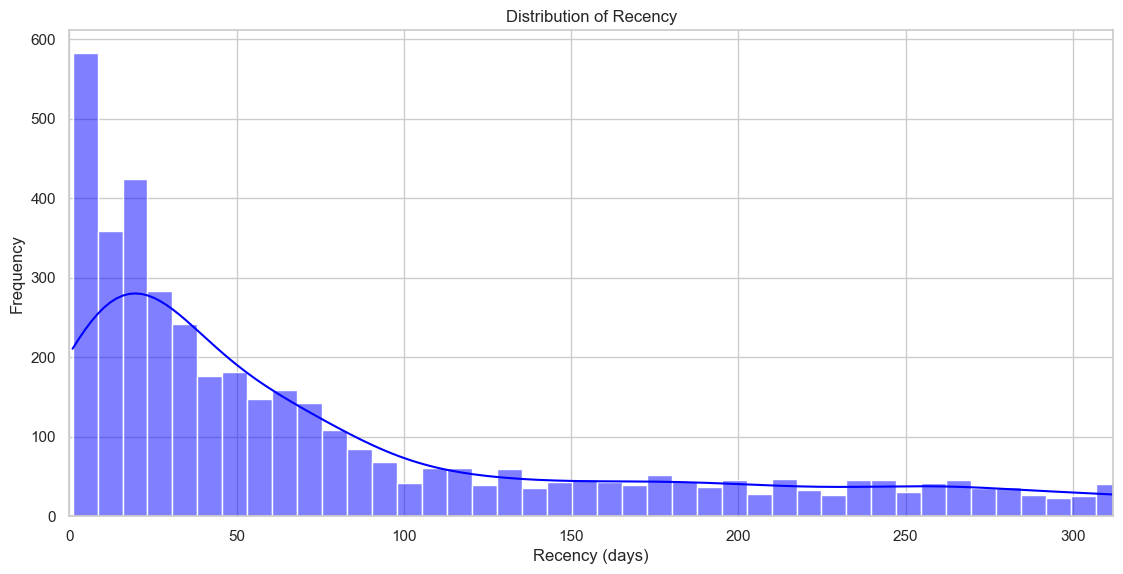

In [19]:
# Distribution of Recency
plt.figure(figsize=(12, 6))
sns.histplot(rfm['Recency'], bins=50, kde=True, color='blue')
plt.title('Distribution of Recency')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency')
plt.xlim(0, rfm['Recency'].quantile(0.95))
plt.show()

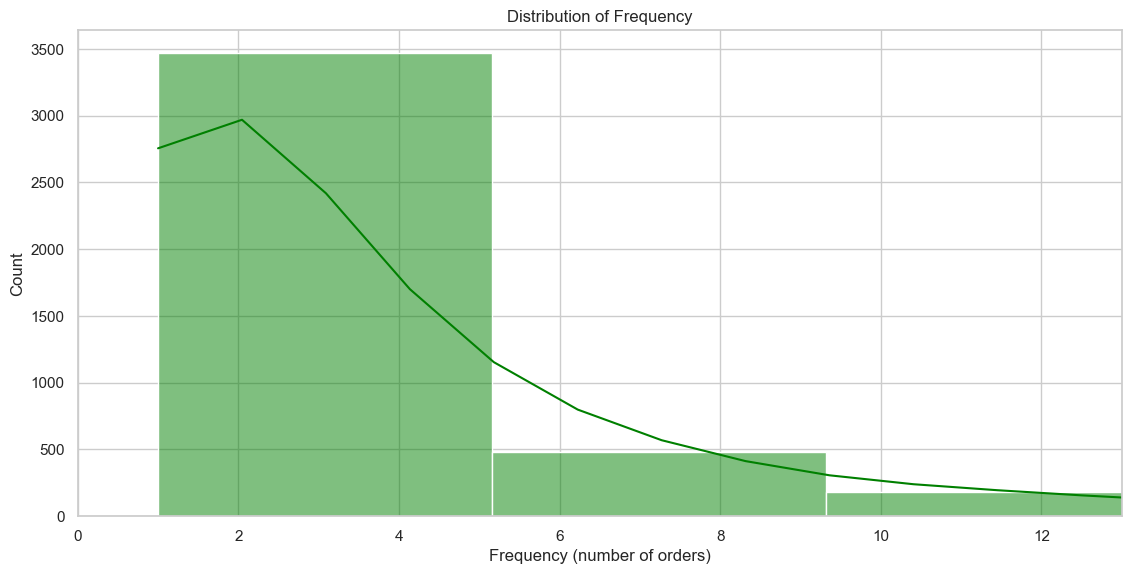

In [20]:
# Distribution of Frequency
plt.figure(figsize=(12, 6))
sns.histplot(rfm['Frequency'], bins=50, kde=True, color='green')
plt.title('Distribution of Frequency')
plt.xlabel('Frequency (number of orders)')
plt.ylabel('Count')
plt.xlim(0, rfm['Frequency'].quantile(0.95))
plt.show()


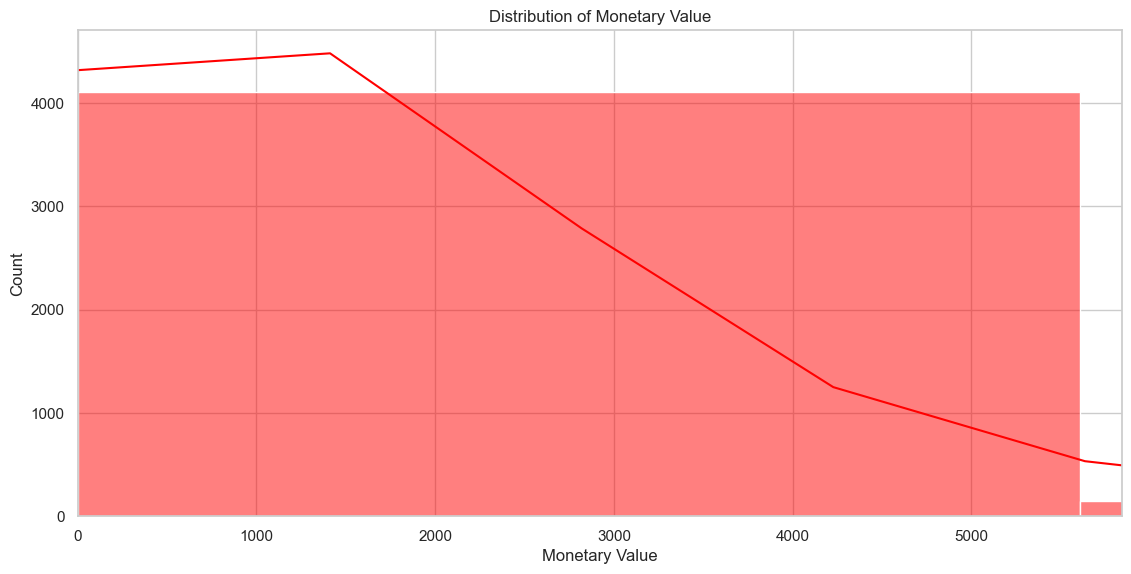

In [21]:
# Distribution of Monetary Value
plt.figure(figsize=(12, 6))
sns.histplot(rfm['Monetary'], bins=50, kde=True, color='red')
plt.title('Distribution of Monetary Value')
plt.xlabel('Monetary Value')
plt.ylabel('Count')
plt.xlim(0, rfm['Monetary'].quantile(0.95))
plt.show()

## 3. K-Means Clustering

In [22]:
# Scale the RFM data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [23]:
# Determine optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

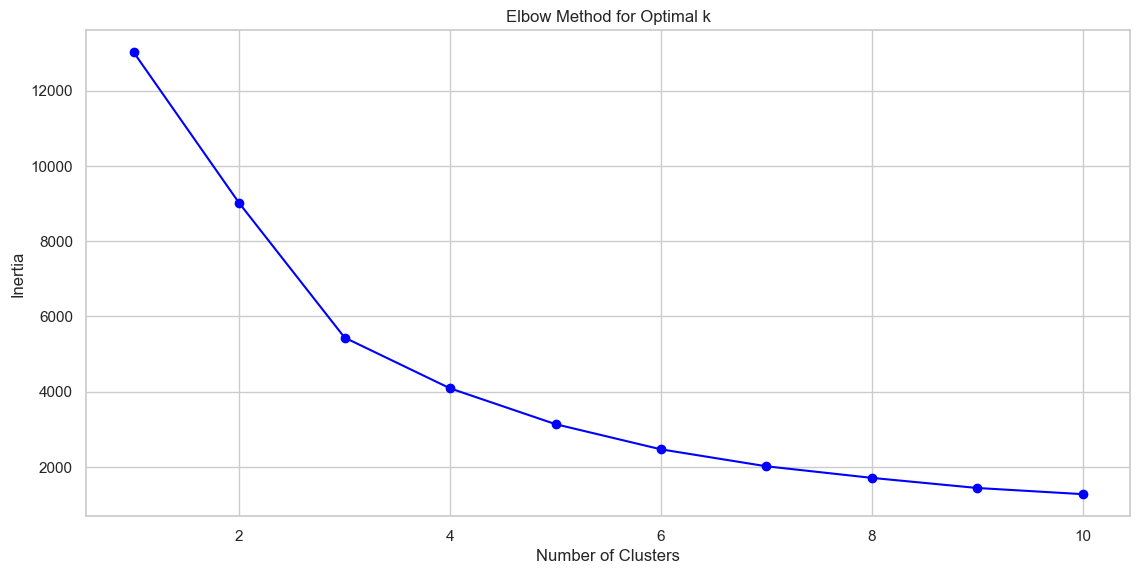

In [24]:
# Elbow Method
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='blue')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [25]:
# Apply K-Means with the optimal number of clusters (let's say 4 based on the elbow method)
optimal_k = 4  # Adjust this based on your elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [26]:
# Calculate silhouette score
silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"\nSilhouette Score: {silhouette_avg}")


Silhouette Score: 0.6160248190563382


In [27]:
# Calculate average RFM values for each cluster
cluster_avg = rfm.groupby('Cluster').mean().reset_index()
print("\nCluster Profiles:")
print(cluster_avg)


Cluster Profiles:
   Cluster     Recency  Frequency       Monetary
0        0  248.564030   1.551789     478.107581
1        1   15.672986  22.047393   12453.225924
2        2    7.384615  82.538462  127338.313846
3        3   43.920380   3.656291    1350.140532


## 4. Advanced Technique 1: Dynamic Segmentation

In [28]:
def create_dynamic_segments(rfm_data, reference_date=None):
    """
    Creates dynamic segments that update based on recent customer behavior
    """
    # Make a copy to avoid modifying the original dataframe
    df = rfm_data.copy()
    
    # Use current date if reference date not provided
    if reference_date is None:
        reference_date = datetime.now()
    
    # Define dynamic segments based on customer behavior patterns
    conditions = [
        (df['Recency'] < 30) & (df['Frequency'] > 10) & (df['Monetary'] > 1000),
        (df['Recency'] < 30) & (df['Frequency'] <= 5),
        (df['Recency'] > 30) & (df['Recency'] < 60) & (df['Frequency'] > 5),
        (df['Recency'] > 90)
    ]
    
    segment_names = [
        'Active High-Value',
        'New Customers',
        'At-Risk Customers',
        'Dormant Customers'
    ]
    
    # Create dynamic segment column
    df['DynamicSegment'] = np.select(conditions, segment_names, default='Regular Customers')
    
    # Track segment changes over time (if previous segment exists)
    if 'PreviousSegment' in df.columns:
        df['SegmentChanged'] = df['DynamicSegment'] != df['PreviousSegment']
    
    df['PreviousSegment'] = df['DynamicSegment']
    df['LastUpdated'] = reference_date
    
    return df

In [29]:
def simulate_dynamic_segmentation(rfm_data, days_list=[90, 60, 30, 0]):
    """
    Simulates dynamic segmentation over time by creating snapshots at different time points
    """
    snapshots = []
    
    # Create snapshots for different time points
    for days_ago in days_list:
        reference_date = datetime.now() - timedelta(days=days_ago)
        
        # For simulation, adjust Recency by the days_ago value
        adjusted_rfm = rfm_data.copy()
        adjusted_rfm['Recency'] = adjusted_rfm['Recency'] - days_ago
        adjusted_rfm['Recency'] = adjusted_rfm['Recency'].clip(lower=0)  # Ensure no negative values
        
        # Apply segmentation
        segment_snapshot = create_dynamic_segments(adjusted_rfm, reference_date)
        segment_snapshot['SnapshotDate'] = reference_date
        snapshots.append(segment_snapshot)

    # Combine snapshots
    segment_history = pd.concat(snapshots)
    
    return segment_history

Segment Distribution Over Time:
DynamicSegment              Active High-Value  At-Risk Customers  \
SnapshotDate                                                       
2024-12-31 17:24:31.553555                332                  8   
2025-01-30 17:24:31.559555                329                 17   
2025-03-01 17:24:31.565555                322                 43   
2025-03-31 17:24:31.569555                295                121   

DynamicSegment              Dormant Customers  New Customers  \
SnapshotDate                                                   
2024-12-31 17:24:31.553555                860           2266   
2025-01-30 17:24:31.559555               1041           2053   
2025-03-01 17:24:31.565555               1217           1584   
2025-03-31 17:24:31.569555               1449            960   

DynamicSegment              Regular Customers  
SnapshotDate                                   
2024-12-31 17:24:31.553555                872  
2025-01-30 17:24:31.559555    

<Figure size 1200x800 with 0 Axes>

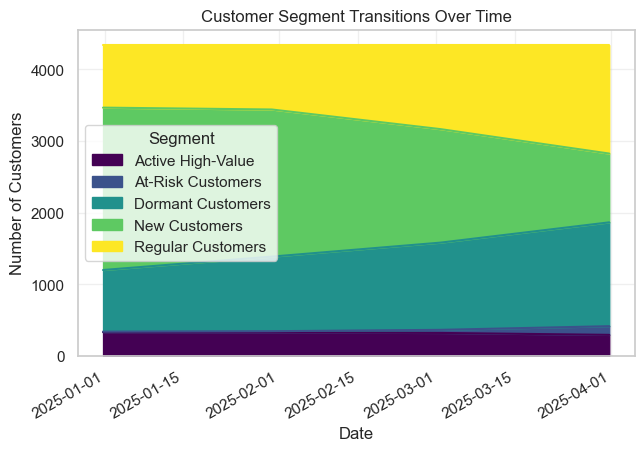

In [30]:
# Apply dynamic segmentation
segment_history = simulate_dynamic_segmentation(rfm)

# Display segment distribution at each time point
print("Segment Distribution Over Time:")
segment_counts = segment_history.groupby(['SnapshotDate', 'DynamicSegment']).size().unstack()
print(segment_counts)

# Visualize segment transitions over time
plt.figure(figsize=(12, 8))
segment_counts.plot(kind='area', stacked=True, colormap='viridis')
plt.title('Customer Segment Transitions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.legend(title='Segment')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Advanced Technique 2: Post-Hoc Segmentation with Hierarchical Clustering

In [31]:
def perform_hierarchical_clustering(rfm_data, max_clusters=10):
    """
    Performs hierarchical clustering on RFM data to discover natural segments
    """
    # Make a copy of the input data
    rfm = rfm_data.copy()
    
    # Standardize the data
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
    
    # Perform hierarchical clustering
    Z = linkage(rfm_scaled, method='ward')
    
    # Plot dendrogram to visualize hierarchical structure
    plt.figure(figsize=(12, 8))
    dendrogram(Z, truncate_mode='level', p=5)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Customers')
    plt.ylabel('Distance')
    plt.axhline(y=15, color='r', linestyle='--')  # Example threshold for cluster formation
    plt.show()
    
    # Determine optimal number of clusters using silhouette score
    silhouette_scores = []
    for n_clusters in range(2, max_clusters+1):
        clusters = fcluster(Z, n_clusters, criterion='maxclust')
        if len(np.unique(clusters)) > 1:  # Ensure we have at least 2 clusters
            score = silhouette_score(rfm_scaled, clusters)
            silhouette_scores.append((n_clusters, score))
    
    # Plot silhouette scores
    clusters, scores = zip(*silhouette_scores)
    plt.figure(figsize=(10, 6))
    plt.plot(clusters, scores, marker='o')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()
    
    # Get optimal number of clusters
    optimal_clusters = max(silhouette_scores, key=lambda x: x[1])[0]
    print(f"Optimal number of clusters: {optimal_clusters}")
    
    # Assign clusters
    clusters = fcluster(Z, optimal_clusters, criterion='maxclust')
    
    # Add cluster assignments to original data
    rfm['HierarchicalCluster'] = clusters
    
    # Analyze the characteristics of each cluster
    cluster_analysis = rfm.groupby('HierarchicalCluster').agg({
        'Recency': ['mean', 'min', 'max'],
        'Frequency': ['mean', 'min', 'max'],
        'Monetary': ['mean', 'min', 'max']
    })
    
    print("\nCluster Profiles:")
    print(cluster_analysis)
    
    return rfm, cluster_analysis

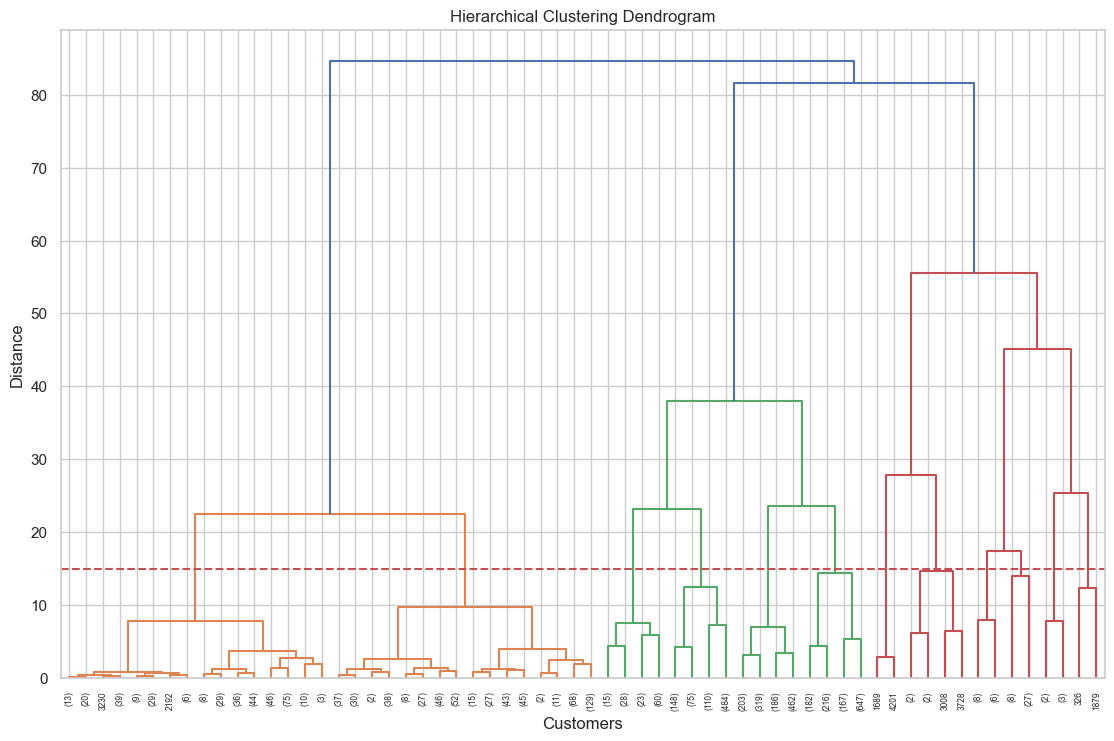

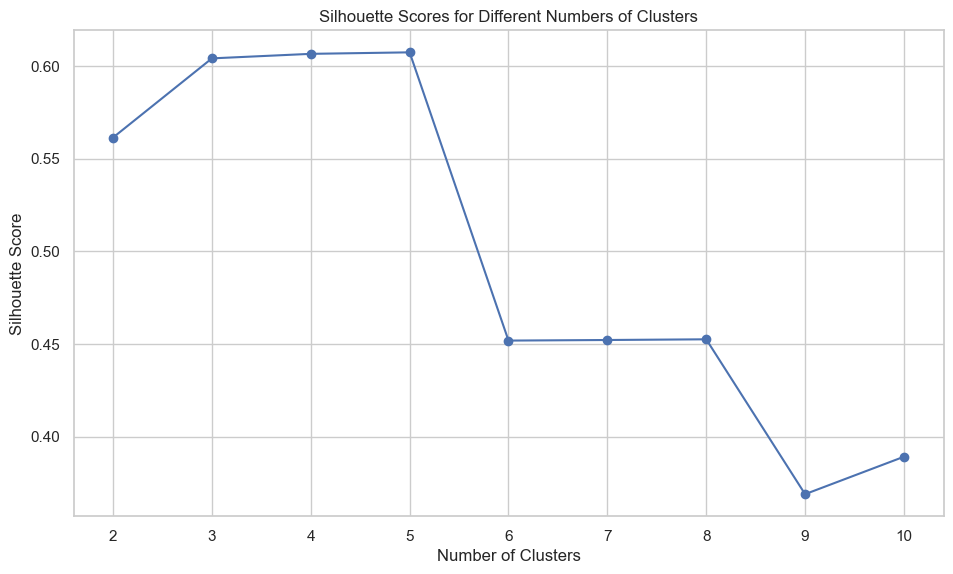

Optimal number of clusters: 5

Cluster Profiles:
                        Recency             Frequency                Monetary  \
                           mean  min  max        mean min  max           mean   
HierarchicalCluster                                                             
1                    259.542677  161  374    1.489989   1    8     457.307820   
2                     46.205414    1  218    4.305263   1   32    1625.457204   
3                     11.000000    1   39   43.875000   2   73  164658.498750   
4                     28.224490    1  372   31.653061   1   62   28449.651837   
5                      1.857143    1    4  128.714286  86  209   51639.521429   

                                          
                          min        max  
HierarchicalCluster                       
1                        3.75    9864.26  
2                        6.20   21429.39  
3                    81024.84  280206.02  
4                     1296.44   77183.60  
5

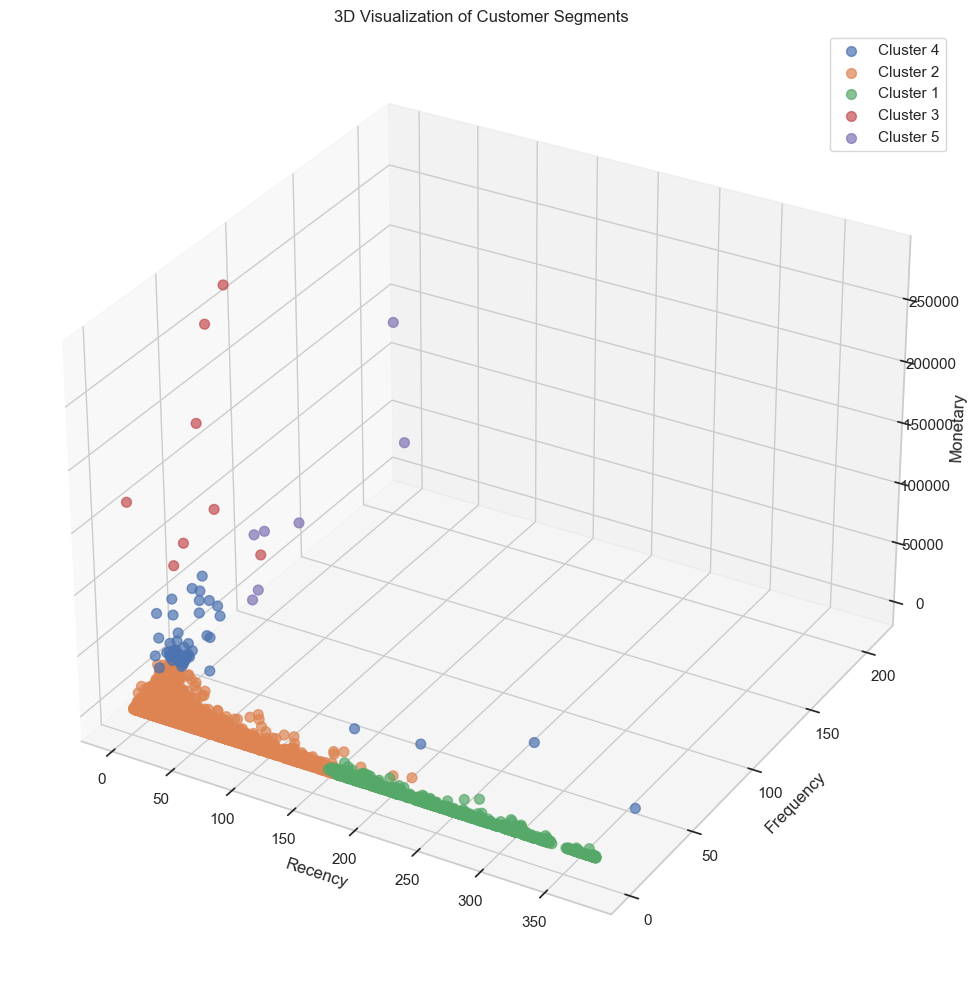

In [32]:
# Apply hierarchical clustering
rfm_with_clusters, cluster_profiles = perform_hierarchical_clustering(rfm)

# %%
# 3D visualization of hierarchical clusters
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

clusters = rfm_with_clusters['HierarchicalCluster'].unique()
for cluster in clusters:
    subset = rfm_with_clusters[rfm_with_clusters['HierarchicalCluster'] == cluster]
    ax.scatter(subset['Recency'], 
               subset['Frequency'], 
               subset['Monetary'], 
               label=f'Cluster {cluster}',
               alpha=0.7,
               s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Visualization of Customer Segments')
plt.legend()
plt.tight_layout()
plt.show()

## 8. Conclusions and Marketing Recommendations

 Based on our analysis, we can draw the following conclusions:
 
 1. **K-means clustering** provided us with distinct customer segments based on RFM values.
 2. **Dynamic segmentation** showed how customers move between segments over time and helps identify:
    - High-value customers who need retention strategies
    - At-risk customers who need re-engagement campaigns
    - Dormant customers who might respond to reactivation offers
 3. **Hierarchical clustering** revealed natural groupings in the data that might not be evident with predefined rules.
 
 
 ### Marketing Recommendations:
 
 1. **For High-Value Customers:**
    - Implement loyalty programs
    - Offer exclusive products/services
    - Provide personalized shopping experiences
 
 2. **For At-Risk Customers:**
    - Create targeted win-back campaigns
    - Offer special discounts or incentives
    - Gather feedback to understand why engagement is decreasing
 
 3. **For New Customers:**
    - Develop onboarding programs
    - Provide educational content about products
    - Offer first-time purchase incentives
 
 4. **For Dormant Customers:**
    - Create reactivation campaigns
    - Offer substantial incentives to return
    - Consider different communication channels


## 8. Save Results

In [35]:
# Save the results
rfm_with_clusters.to_csv('advanced_customer_segments.csv')
print("Advanced customer segmentation completed and saved to 'advanced_customer_segments.csv'") 

Advanced customer segmentation completed and saved to 'advanced_customer_segments.csv'
